# Simulations of cross-diffusion system

In [2]:
import numpy as np
from numpy import array

## Initial functions

D_X(V,h) returns the scalar field given by $\frac{V(x+h,y) - V(x,y)}{h}$, a discretisation of the $\frac{\partial}{\partial x}$ operator, and G_X(V,h) returns the scalar field $\frac{V(x+h,y) + V(x,y)}{2}$, a local averaging.

In [3]:
def D_X(V,h):
    direction = -int(np.sign(h))
    return (np.roll(V,direction,axis=1) -np.roll(V,-direction,axis=1) )/(2*h)

def D_Y(V,h):
    direction = -int(np.sign(h))
    return (np.roll(V,direction,axis=0) -np.roll(V,-direction,axis=0))/(2*h)
def D(V,h):
    return array([D_X(V,h),D_Y(V,h)])
def div(V,h):
    return D_X(V[0],h) + D_Y(V[1],h)

evolve takes in initial conditions, system parameters and the time increment dt and total number of time steps to be taken and evolves the system for that many time steps.
At each time step the next iteration of the time step is computed. This can be done using forward euler, backwards euler or crank_nicholson method.

There is an early termination condition for the evolution of the system. If at any point $\underline{\rho} \not\in \mathcal{D}$ or $\vert \vert \delta \underline{\rho}\vert \vert_{L^2} < minChange$, then the evolve funciton is terminated and the system up to that point is outputted.

The output of the evolve funciton is rho_t_1,rho_t_2,t, wher rho_t_i is an $TimeSteps\times N \times N$ array where $N$ is the space discretisation parameter. 

In [4]:
def evolve(rho_10,rho_20,dt,D1,D2,EndTime,minChange,method = 'forward_euler'):
    TimeSteps = int(EndTime/dt)
    rho_1 = rho_10
    rho_2 = rho_20
    t = 0
    MaxSize = 1000
    if TimeSteps < MaxSize:
        scale = 1
        rho_t_1 = np.zeros((1+TimeSteps,N,N))
        rho_t_2 = np.zeros((1+TimeSteps,N,N))
    else:
        scale = round(TimeSteps/MaxSize)
        rho_t_1 = np.zeros((MaxSize+1,N,N))
        rho_t_2 = np.zeros((MaxSize+1,N,N))
    i = 0
    rho_t_1[i] = rho_1
    rho_t_2[i] = rho_2
    LastUpdate= 0
    while i< TimeSteps:
        if method == 'forward_euler':
            rho_1,rho_2,Magnitude_change =  forward_euler(rho_1,rho_2,dt,D1,D2)
        elif method == 'crank_nicholson':
            rho_1,rho_2,Magnitude_change =  crank_nicholson(rho_1,rho_2,dt,D1,D2)
        elif method == 'backwards_euler':
            rho_1,rho_2,Magnitude_change =  backwards_euler(rho_1,rho_2,dt,D1,D2)

        t +=dt
        i += 1
        if int((100*i/TimeSteps)%5) ==0 and int(100*i/TimeSteps) >0 and int((100*i/TimeSteps))>LastUpdate: 
            print(str(int((100*i/TimeSteps))) + "% completed. Current value of dp/dt = "+ str(Magnitude_change))
            LastUpdate = int((100*i/TimeSteps))
        if i%scale == 0:
            rho_t_1[int(i/scale)] = rho_1
            rho_t_2[int(i/scale)] = rho_2
        if len(np.argwhere(rho_1 <0 )) >0 or  len(np.argwhere(rho_2 <0 )) >0 or  len(np.argwhere(rho_1 +rho_2>1 )) >0 or Magnitude_change < minChange:
            print('ended early at  i='+str(i))
            print('np.argwhere(rho_1 <0 ) = ' + str(np.argwhere(rho_1 <0 )))
            print('np.argwhere(rho_1 +rho_2>1 ) = ' + str(np.argwhere(rho_1 +rho_2>1 )))
            print('np.argwhere(rho_ <0 ) = ' + str(np.argwhere(rho_2 <0 )))
            print('Magnitude_change = ' +str(Magnitude_change))
            return rho_t_1[:int((i+1)/scale),:,:],rho_t_2[:int((i+1)/scale),:,:],np.linspace(0,dt*(i+1),int((i+1)/scale))
            break
        #print('Got to i = ' +str(i)+', successfully!')
    
    return rho_t_1,rho_t_2,np.linspace(0,dt*(i+1),int((i+1)/scale))
def forward_euler(rho_1,rho_2,dt,D1,D2):
    delta_rho = dp(rho_1,rho_2,D1,D2)
    rhos_new = array([rho_1,rho_2])
    rhos_new +=  dt*delta_rho
    Magnitude_change = np.sqrt(np.sum(delta_rho**2)*(h**2))
    rhos_new = array([rho_1,rho_2])
    rhos_new +=  dt*delta_rho
    Magnitude_change = np.sqrt(np.sum(delta_rho**2)*(h**2))
    #print(np.sqrt(np.amax( (J_plus_X - J_minus_X + J_plus_Y - J_minus_Y)**2)))
    return rhos_new[0],rhos_new[1],Magnitude_change

def crank_nicholson(rho_1,rho_2,dt,D1,D2):
    rhos_0 = array([rho_1,rho_2])
    dp0 = dp(rhos_0[0],rhos_0[1],D1,D2)
    phi = lambda rhos: rhos_0 + (dt/2)*(dp0 + dp(rhos[0],rhos[1],D1,D2))
    rhos = rhos_0 + dt*dp0
    for k in range(0,20):
        new_rhos = phi(rhos)
        if np.linalg.norm(new_rhos - rhos)*h < 1e-8:
           # print("Crank-Nicholson converged after "  +str(k) + " Error  = " + str(np.linalg.norm(new_rhos - rhos)))
            break
        rhos = new_rhos
    delta_rho = (rhos - rhos_0)/dt
    Magnitude_change = np.sqrt(np.sum(delta_rho**2)*(h**2))
    #print(np.sqrt(np.amax( (J_plus_X - J_minus_X + J_plus_Y - J_minus_Y)**2)))
    return rhos[0],rhos[1],Magnitude_change

def backwards_euler(rho_1,rho_2,dt,D1,D2):
    rhos_0 = array([rho_1,rho_2])
    dp0 = dp(rhos_0[0],rhos_0[1],D1,D2)
    phi = lambda rhos: rhos_0 + (dt)*(dp(rhos[0],rhos[1],D1,D2))
    rhos = rhos_0 + dt*dp0
    for k in range(0,20):
        new_rhos = phi(rhos)
        if np.linalg.norm(new_rhos - rhos)*h < 1e-12:
           # print("Crank-Nicholson converged after "  +str(k) + " Error  = " + str(np.linalg.norm(new_rhos - rhos)))
            break
        rhos = new_rhos
    delta_rho = (rhos - rhos_0)/dt
    Magnitude_change = np.sqrt(np.sum(delta_rho**2)*(h**2))
    #print(np.sqrt(np.amax( (J_plus_X - J_minus_X + J_plus_Y - J_minus_Y)**2)))
    return rhos[0],rhos[1],Magnitude_change

In [5]:
alpha = np.pi/2 - 1
def dp(rho_1,rho_2,D1,D2):   # value of \partial_t (\rho_1,\rho_2)
    g1 = 2*D1/(D1 +D2)
    g2 = 2*D2/(D1 +D2)
    rho = rho_1 +rho_2
    Drho_1 = D(rho_1,h)
    Drho_2 = D(rho_2,h)
    Drho = D(rho,h)
    DV1 = DV_1(X,Y)
    DV2 = DV_2(X,Y)
    C = (D1+D2)*g1*g2*alpha/2
    W_1 = D1*(1-rho)*(1-g1*alpha*rho_1)*Drho_1 + D1*rho_1*(1-g1*alpha*rho)*Drho + D1*(1-rho)*rho_1*(1-g1*alpha*rho_1)*DV1 +C*(rho_1*(1-rho)*Drho_2 + rho_1*rho_2*Drho+rho_1*rho_2*(1-rho)*DV2)
    W_2 = D2*(1-rho)*(1-g2*alpha*rho_2)*Drho_2 + D2*rho_2*(1-g2*alpha*rho)*Drho + D2*(1-rho)*rho_2*(1-g2*alpha*rho_2)*DV2 +C*(rho_2*(1-rho)*Drho_1 + rho_2*rho_1*Drho+rho_2*rho_1*(1-rho)*DV1)
    J_1 = div(W_1,h)
    J_2 = div(W_2,h)
    return array([J_1,J_2])

In [11]:
def M(rho_1,rho_2,D1,D2):
    g1 = 2*D1/(D1 +D2)
    g2 = 2*D2/(D1 +D2)
    rho = rho_1 + rho_2
    M = np.array([[D1*rho_1*(1-rho)*(1-g1*alpha*rho_2),(D1+D2)*g1*g2*alpha*(1-rho)*rho_1*rho_2/2],[(D1+D2)*g1*g2*alpha*(1-rho)*rho_1*rho_2/2,D2*rho_2*(1-rho)*(1-g2*alpha*rho_1)]])
    return M
    

def dw(rho_1,rho_2,D1,D2):   # value of \partial_t (\rho_1,\rho_2)
    g1 = 2*D1/(D1 +D2)
    g2 = 2*D2/(D1 +D2)
    rho = rho_1 +rho_2
    Drho_1 = D(rho_1,h)
    Drho_2 = D(rho_2,h)
    Drho = D(rho,h)
    DV1 = DV_1(X,Y)
    DV2 = DV_2(X,Y)
    return array([ Drho_1/rho + Drho/(1-rho) + DV1,Drho_2/rho + Drho/(1-rho) + DV2 ])
def dE(rho_1,rho_2,D1,D2):
    v=dw(rho_1,rho_2,D1,D2)
    Mob = M(rho_1,rho_2,D1,D2)
    return np.einsum( 'ijkl,ijkl' ,v,(np.einsum( 'itkl,tjkl->ijkl', Mob,v)))*(h**2)

## Evolving the system
---


In [38]:
def makeSystem(N, dim = 2):
    h = 1/N
    Omega = np.meshgrid(np.linspace(0,1-h,N),np.linspace(0,1-h,N))
    return Omega, h,N

Omega, h,N = makeSystem(100, dim = 2)

X,Y =Omega

In [74]:
D1 = 1
D2 = 20
rho_10 = 0*X +.93
rho_20 = 0*X +.06
V_1 = lambda x,y : 0*np.sin(2*np.pi*x)/20
V_2 = lambda x,y :  -np.sin(2*np.pi*x) # 0*np.cos(2*np.pi*x)
DV_1 = lambda x,y: 0*array( [2*np.pi*np.cos( 2*np.pi*x)/20, 0*x])
DV_2 = lambda x,y: -array( [2*np.pi*np.cos( 2*np.pi*x), 0*x]) #0*array( [-2*np.pi*np.sin( 2*np.pi*x), 0*x ])
rho_t_1,rho_t_2,t = evolve(rho_10,rho_20,.1*h**2,D1,D2,1,0.005, 'forward_euler')
rho_t_1_alt,rho_t_2_alt,t_alt = alt_evolve(rho_10,rho_20,.1*h**2,D1,D2,1,0.005, 'forward_euler')


5% completed. Current value of dp/dt = 0.2877487947032758
10% completed. Current value of dp/dt = 0.23156499895645835
15% completed. Current value of dp/dt = 0.1890119753639798
20% completed. Current value of dp/dt = 0.13004961806572113
25% completed. Current value of dp/dt = 0.08158045467303943
30% completed. Current value of dp/dt = 0.050163016999282425
35% completed. Current value of dp/dt = 0.03093490916219099
40% completed. Current value of dp/dt = 0.01922314601901579
45% completed. Current value of dp/dt = 0.012029232688270407
50% completed. Current value of dp/dt = 0.007566808823761352
ended early at  i=54503
np.argwhere(rho_1 <0 ) = []
np.argwhere(rho_1 +rho_2>1 ) = []
np.argwhere(rho_ <0 ) = []
Magnitude_change = 0.004999606076363605
5% completed. Current value of dp/dt = 0.0072762979515370325
10% completed. Current value of dp/dt = 0.00623960840041768
15% completed. Current value of dp/dt = 0.0061213148540761935
20% completed. Current value of dp/dt = 0.006110345886064612
25%

In [116]:
rho_10 = 0*X +.4
rho_20 = 0*X +.4
V_1 = lambda x,y : np.sin(2*np.pi*x)
V_2 = lambda x,y :  -np.sin(2*np.pi*x) # 0*np.cos(2*np.pi*x)
DV_1 = lambda x,y: array( [2*np.pi*np.cos( 2*np.pi*x), 0*x])
DV_2 = lambda x,y: -array( [2*np.pi*np.cos( 2*np.pi*x), 0*x]) #0*array( [-2*np.pi*np.sin( 2*np.pi*x), 0*x ])
D1 = 1
D2 = 1
rho_t_1,rho_t_2,t = evolve(rho_10,rho_20,.1*h**2,D1,D2,1,0.005, 'forward_euler')
rho_t_1_alt,rho_t_2_alt,t_alt = alt_evolve(rho_10,rho_20,.1*h**2,D1,D2,1,0.005, 'forward_euler')


5% completed. Current value of dp/dt = 1.3923001623486122
10% completed. Current value of dp/dt = 1.1089865883098946
15% completed. Current value of dp/dt = 0.8617813001366655
20% completed. Current value of dp/dt = 0.6531241378277455
25% completed. Current value of dp/dt = 0.4837421031783718
30% completed. Current value of dp/dt = 0.3513430901543886
35% completed. Current value of dp/dt = 0.25119773454611005
40% completed. Current value of dp/dt = 0.17743699381656144
45% completed. Current value of dp/dt = 0.12421136696639098
50% completed. Current value of dp/dt = 0.08638485418330312
55% completed. Current value of dp/dt = 0.0597979492184575
60% completed. Current value of dp/dt = 0.041257780439571914
65% completed. Current value of dp/dt = 0.02840056490151819
70% completed. Current value of dp/dt = 0.019518876490738628
75% completed. Current value of dp/dt = 0.013399954679350387
80% completed. Current value of dp/dt = 0.009192241527622309
85% completed. Current value of dp/dt = 0.00

## Alternate numerical scheme
---
This scheme directly computes $M$ and $\nabla w$ separtely and then applies matrix multiplication and numerical divergence. This seems to give different results for the evolution of the system

In [47]:
def alt_evolve(rho_10,rho_20,dt,D1,D2,EndTime,minChange,method = 'forward_euler'):
    TimeSteps = int(EndTime/dt)
    rho_1 = rho_10
    rho_2 = rho_20
    t = 0
    MaxSize = 1000
    if TimeSteps < MaxSize:
        scale = 1
        rho_t_1 = np.zeros((1+TimeSteps,N,N))
        rho_t_2 = np.zeros((1+TimeSteps,N,N))
    else:
        scale = round(TimeSteps/MaxSize)
        rho_t_1 = np.zeros((MaxSize+1,N,N))
        rho_t_2 = np.zeros((MaxSize+1,N,N))
    i = 0
    rho_t_1[i] = rho_1
    rho_t_2[i] = rho_2
    LastUpdate= 0
    while i< TimeSteps:
        if method == 'forward_euler':
            rho_1,rho_2,Magnitude_change =  alt_forward_euler(rho_1,rho_2,dt,D1,D2)
        elif method == 'crank_nicholson':
            rho_1,rho_2,Magnitude_change =  crank_nicholson(rho_1,rho_2,dt,D1,D2)
        elif method == 'backwards_euler':
            rho_1,rho_2,Magnitude_change =  backwards_euler(rho_1,rho_2,dt,D1,D2)

        t +=dt
        i += 1
        if int((100*i/TimeSteps)%5) ==0 and int(100*i/TimeSteps) >0 and int((100*i/TimeSteps))>LastUpdate: 
            print(str(int((100*i/TimeSteps))) + "% completed. Current value of dp/dt = "+ str(Magnitude_change))
            LastUpdate = int((100*i/TimeSteps))
        if i%scale == 0:
            rho_t_1[int(i/scale)] = rho_1
            rho_t_2[int(i/scale)] = rho_2
        if len(np.argwhere(rho_1 <0 )) >0 or  len(np.argwhere(rho_2 <0 )) >0 or  len(np.argwhere(rho_1 +rho_2>1 )) >0 or Magnitude_change < minChange:
            print('ended early at  i='+str(i))
            print('np.argwhere(rho_1 <0 ) = ' + str(np.argwhere(rho_1 <0 )))
            print('np.argwhere(rho_1 +rho_2>1 ) = ' + str(np.argwhere(rho_1 +rho_2>1 )))
            print('np.argwhere(rho_ <0 ) = ' + str(np.argwhere(rho_2 <0 )))
            print('Magnitude_change = ' +str(Magnitude_change))
            return rho_t_1[:int((i+1)/scale),:,:],rho_t_2[:int((i+1)/scale),:,:],np.linspace(0,dt*(i+1),int((i+1)/scale))
            break
        #print('Got to i = ' +str(i)+', successfully!')
    
    return rho_t_1,rho_t_2,np.linspace(0,dt*(i+1),int((i+1)/scale))
def alt_forward_euler(rho_1,rho_2,dt,D1,D2):
    v=dw(rho_1,rho_2,D1,D2)
    Mob = M(rho_1,rho_2,D1,D2)
    F = np.einsum( 'itkl,tjkl->ijkl', Mob,v)
    J1 = div(F[0,:,:],h)
    J2 = div(F[1,:,:],h)
    delta_rho = array([J1,J2])
    rhos_new = array([rho_1,rho_2])
    rhos_new +=  dt*delta_rho
    Magnitude_change = np.sqrt(np.sum(delta_rho**2)*(h**2))
    #print(np.sqrt(np.amax( (J_plus_X - J_minus_X + J_plus_Y - J_minus_Y)**2)))
    return rhos_new[0],rhos_new[1],Magnitude_change

## Visualisation
---
Here an animation is created showing the evolution of the individual densities along side the energy potentials $V$.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

In [27]:
def makePlot(Time_length,Title,rho_t_1,rho_t_2,t):
    scale = int(rho_t_1.shape[0]/(Time_length*20))
    fig = plt.figure(figsize=(12,5))
    ax = plt.subplot(1,2,1)   
    txt_title = ax.set_title('')
    ax.set_xlim(( 0, 1))            
    ax.set_ylim((-1, 1))
    line1, = ax.plot([], [], 'b', lw=2, label = 'rho_1')  
    line2, = ax.plot([], [], 'r', lw=2, label = 'rho_2')  
    line3, = ax.plot([], [], 'g', lw=2, label = 'V_1')  
    line4, = ax.plot([], [], 'y', lw=2, label = 'V_2')  
    ax.legend()
    def animate(i): 
         # grab a random integer to be the next y-value in the animation
        x = np.linspace(0,1-h,N)
        y1 = rho_t_1[scale*i,0,:] #+  rho_t_2[i,:,0]
        y2 = rho_t_2[scale*i,0,:]
        line1.set_data(x, y1)
        line2.set_data(x, y2)
        line3.set_data(x, V_1(x,0))
        line4.set_data(x,  V_2(x,0))
        txt_title.set_text('t = {0:4f}'.format(t[scale*i]))
        return line1,line2,line3,line4,
    ani = FuncAnimation(fig, animate, frames=Time_length*20, interval=20,  blit=True)
    ani.save(Title + '.mp4', writer = 'ffmpeg', fps = 30)

In [114]:
def makePlotMatrixDeterminant(Time_length,Title,rho_t_1,rho_t_2,t):
    scale = int(rho_t_1.shape[0]/(Time_length*20))
    fig = plt.figure(figsize=(12,5))
    ax = plt.subplot(1,2,1)   
    txt_title = ax.set_title('')
    ax.set_xlim(( 0, 1))                
    Max_value = 1e-6
    for j in range(0,len(t)):
        Mob =M(rho_t_1[j,0,:],rho_t_2[j,0,:],D1,D2)
        x = np.linspace(0,1-h,N)
        y1 =Mob[0,0,:]*Mob[1,1,:] - Mob[0,1,:]*Mob[1,0,:]
        if np.amax(abs(y1)) > Max_value:
            Max_value = np.amax(abs(y1))
    
    ax.set_ylim((-1.5*Max_value,1.5*Max_value))    
    line1, = ax.plot([], [], 'b', lw=2, label = 'det(M)')
    ax.legend()
    def animate(i): 
         # grab a random integer to be the next y-value in the animation
        Mob =M(rho_t_1[scale*i,0,:],rho_t_2[scale*i,0,:],D1,D2)
        x = np.linspace(0,1-h,N)
        y1 =Mob[0,0,:]*Mob[1,1,:] - Mob[0,1,:]*Mob[1,0,:]
        line1.set_data(x, y1)
        txt_title.set_text('t = {0:4f}'.format(t[scale*i]))
        return line1,
    ani = FuncAnimation(fig, animate, frames=Time_length*20, interval=20,  blit=True)
    ani.save(Title + '.mp4', writer = 'ffmpeg', fps = 30)

In [115]:
makePlot(20,'System evolution unstable values expanded method',rho_t_1,rho_t_2,t)
makePlot(20,'System evolution unstable values gradient flow method',rho_t_1_alt,rho_t_2_alt,t_alt)

makePlotMatrixDeterminant(20,'Expanded method unstable values Matrix determinant',rho_t_1,rho_t_2,t)
makePlotMatrixDeterminant(20,'Gradient flow method unstable values Matrix determinant',rho_t_1_alt,rho_t_2_alt,t_alt)

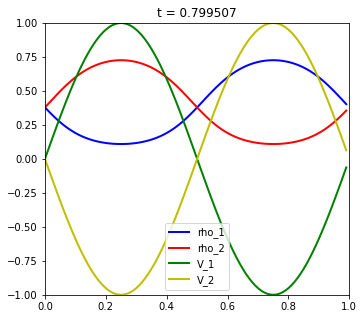

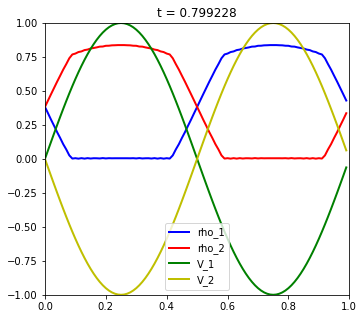

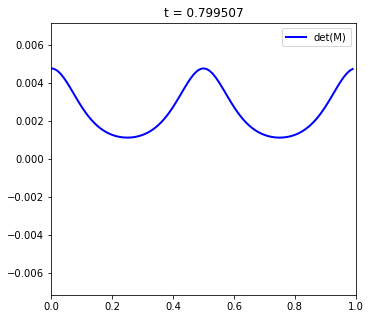

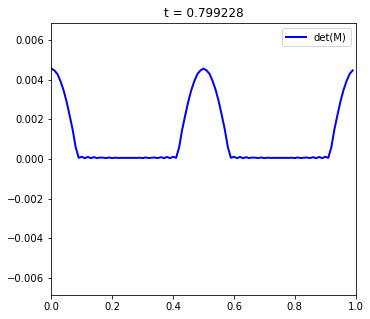

In [119]:
makePlot(20,'System evolution stable values expanded method',rho_t_1,rho_t_2,t)
makePlot(20,'System evolution stable values gradient flow method',rho_t_1_alt,rho_t_2_alt,t_alt)
makePlotMatrixDeterminant(20,'Expanded method stable values Matrix determinant',rho_t_1,rho_t_2,t)
makePlotMatrixDeterminant(20,'Gradient flow method stable values Matrix determinant',rho_t_1_alt,rho_t_2_alt,t_alt)


Final plot of densities

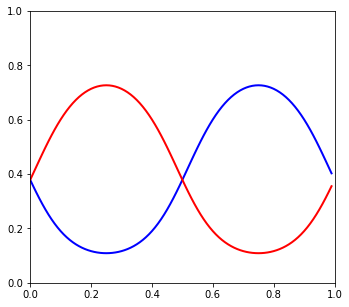

In [68]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)   
txt_title = ax.set_title('')
ax.set_xlim(( 0, 1))            
ax.set_ylim((0, 1))
line1, = ax.plot([], [], 'b', lw=2)  
line2, = ax.plot([], [], 'r', lw=2)  

x = np.linspace(0,1-h,N)
y1 = rho_t_1[-2,0,:]
line1.set_data(x, y1)
y2 = rho_t_2[-2,0,:]
line2.set_data(x, y2)

Plotting evolution of Entropy functional

In [121]:
def E(rho_1,rho_2):
    I1 = np.nonzero(rho_1)
    I2 = np.nonzero(rho_2)
    rho = rho_1 +rho_2
    I3 = np.nonzero(1-rho)
    E_0 = h**2*(np.sum(rho_1[I1]*np.log(rho_1[I1])) +np.sum(rho_2[I2]*np.log(rho_2[I2]))  +np.sum((1- rho[I3])*np.log(1-rho[I3])))
    E_V = h**2*np.sum(rho_1*V_1(X,Y) + rho_2*V_2(X,Y))
    return E_0 +E_V
Entropy =0*t
Entropy_alt =0*t_alt

for j in range(0,len(t)):
    Entropy[j] = E(rho_t_1[j],rho_t_2[j])
for j in range(0,len(t_alt)):
    Entropy_alt[j] = E(rho_t_1_alt[j],rho_t_2_alt[j])

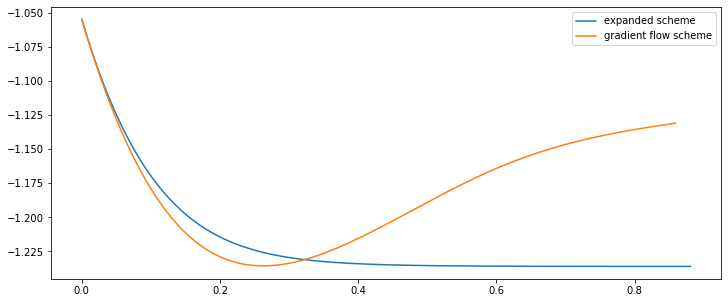

In [122]:
fig = plt.figure(figsize=(12,5))

plt.plot(t,Entropy, label = 'expanded scheme')

plt.plot(t_alt,Entropy_alt, label = 'gradient flow scheme')
plt.legend()
plt.show()

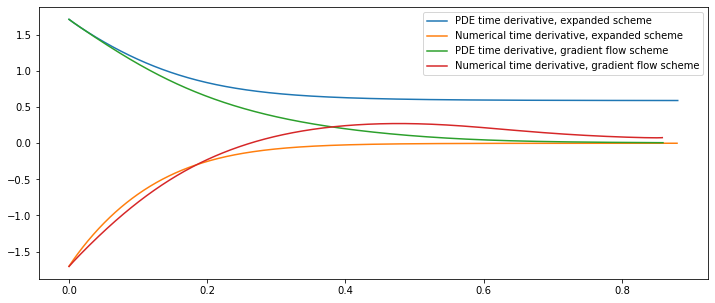

In [124]:
dt_entropy =0*t
for j in range(0,len(t)):
    dt_entropy[j] = dE(rho_t_1[j],rho_t_2[j],D1,D2)
dt_entropy_alt =0*t_alt
for j in range(0,len(t_alt)):
    dt_entropy_alt[j] = dE(rho_t_1_alt[j],rho_t_2_alt[j],D1,D2)

fig = plt.figure(figsize=(12,5))
plt.plot(t,dt_entropy,label = 'PDE time derivative, expanded scheme')
plt.plot(t[:-1],(Entropy[1:]-Entropy[:-1])/(t[1]-t[0]), label = 'Numerical time derivative, expanded scheme')
plt.plot(t_alt,dt_entropy_alt,label = 'PDE time derivative, gradient flow scheme')
plt.plot(t_alt[:-1],(Entropy_alt[1:]-Entropy_alt[:-1])/(t_alt[1]-t_alt[0]), label = 'Numerical time derivative, gradient flow scheme')
plt.legend()
plt.show()

Comparing forward-euler with Crank-Nicholson. It was found that both produced solutions that were reasonably close, however the forward-euler method runs significantly quicker. Conclusion: for most experiments it is sufficient to use the forward_euler method.

In [ ]:
import time

start_time = time.time()

rho_t_1_forward_euler,rho_t_2_forward_euler,t_forward_euler = evolve(rho_10,rho_20,h**2,D1,D2,1,0.005, 'forward_euler')
forward_euler_time = time.time() - start_time
rho_t_1_crank_nicholson,rho_t_2_crank_nicholson,t_crank_nicholson = evolve(rho_10,rho_20,h**2,D1,D2,1,0.005, 'crank_nicholson')
crank_nicholson_time = time.time() - start_time - forward_euler_time

error = np.sqrt(np.sum((rho_t_1_forward_euler - rho_t_1_crank_nicholson)**2 +(rho_t_2_forward_euler- rho_t_2_crank_nicholson)**2)*h**2)/(t_forward_euler[-1] - t_forward_euler[0])

print('error =' + str(error))
print('forward_euler took ' + str(forward_euler_time) + ' seconds')
print('crank_nicholson took ' + str(crank_nicholson_time) + ' seconds')